In [2]:

import sys
from pathlib import Path
import sys
parent_path = Path.cwd().parents[2]
sys.path.append(str(parent_path))


from src.utils import config_utils
#from config import config_utils_v1 as config_utils
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels


### Setting Up the Annotation Harmonization

Different samples may have different annotation labels.  
To ensure consistency across samples, we define a function that *maps annotation names to a unified standard*, using a manually curated dictionary.



In [13]:
def unify_annotations(df, column_name, dataset):
    replace_dict = {}

    replace_dict.update({
        'stroma_fibroblastic_IC high': 'stroma_fibroblastic',
        'stroma_fibroblastic_IC med': 'stroma_fibroblastic',
        'tumor&stroma IC med to high': 'tumor&stroma',
        'IC aggregate_submucosa': 'IC aggregate',
        'IC aggregate_muscularis or stroma': 'IC aggregate',
        'IC aggregregate_submucosa': 'IC aggregate',
        'tumor&stroma IC med to high': 'tumor&stroma',
        'tumor&stroma_IC med to high': 'tumor&stroma',
    
        
    })
    
    df[column_name].replace(replace_dict, inplace=True)
    return df
        
        



###  Experiment Configuration


In [14]:
gt_column_name= 'Pathologist Annotations' 
colname_in_pred = 'Model Prediction'


dataset="Sample_SN048_A121573_Rep2" # options Sample_SN048_A121573_Rep2, Sample_SN123_A595688_Rep1
mode = 'multimodal' # options: unimodal, multimodal

save_dir = "../../../results/transfer_learning_test/"
# create save directory if it does not exist
os.makedirs(save_dir, exist_ok=True)

config_file_path = f'../../../config_files/experiments/annotation_transfer/{dataset}/'
pathologist_annotations = f'../../../../data/ColorectalCancer/{dataset}/PathologistAnnotations.csv'

In [15]:
gt_data = pd.read_csv(pathologist_annotations)
# unify annotations
gt_data = unify_annotations(gt_data, gt_column_name, dataset)
gt_data.set_index('Barcode', inplace=True)
gt_index = gt_data.index

### Evaluating annotation transfer


In [16]:
# make list of config files (since there are 3 repetions for each dataset)
config_files_list = []
for file in os.listdir(config_file_path):
    if file.endswith('.json'): 
        config_files_list.append(os.path.join(config_file_path, file))

print("Total config files found:", len(config_files_list))

Total config files found: 6


In [17]:
# sort config files by name
config_files_list.sort()

# remove if multimodal is present in name
if mode == 'multimodal':
    configs_to_evaluate = [x for x in config_files_list if mode in x]
else:
    configs_to_evaluate = [x for x in config_files_list if 'multimodal' not in x]




************************************************
../../../config_files/experiments/annotation_transfer/Sample_SN048_A121573_Rep2/config_UNI_multimodal_Least_confidence_sampling_computed_features_norm_im_0_norm_ge_0_ICF_0.json
************************************************
Weighted F1: 0.6767545377640706
Kappa: 0.6158437573617772
[[379  37   1  29   3   2   1]
 [ 12 188   8   7   5   6  15]
 [  3   7  88   3  59  17   0]
 [154 133   8 242   7  34   0]
 [  3   8  19   8 605   5 104]
 [  9  49  22  81   5 244   0]
 [  3   7   1   0  30   0 220]]


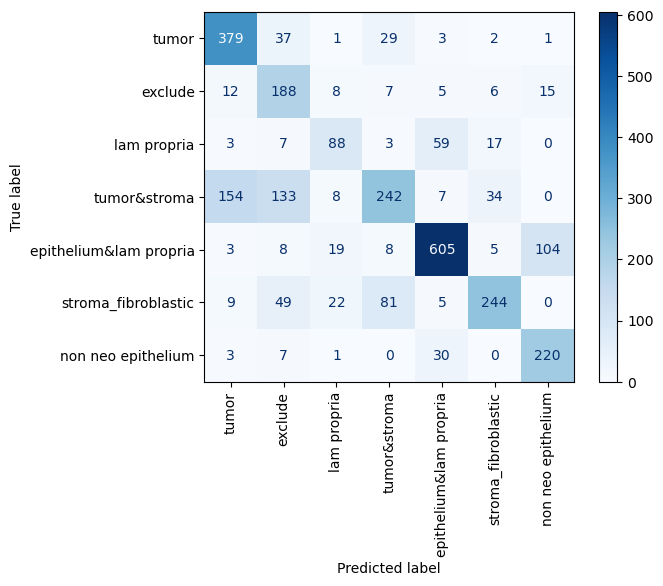

************************************************
../../../config_files/experiments/annotation_transfer/Sample_SN048_A121573_Rep2/config_UNI_multimodal_Least_confidence_sampling_computed_features_norm_im_0_norm_ge_0_ICF_1.json
************************************************
Weighted F1: 0.6705270251486772
Kappa: 0.6072616672497355
[[382  28   2  38   1   1   1]
 [ 12 188   5  10   3   9  14]
 [  2   9  70  16  56  23   1]
 [144 131   3 266   6  27   1]
 [  4  10  20  15 579   5 119]
 [ 10  56  20  86   3 235   0]
 [  2   8   1   0  25   0 225]]


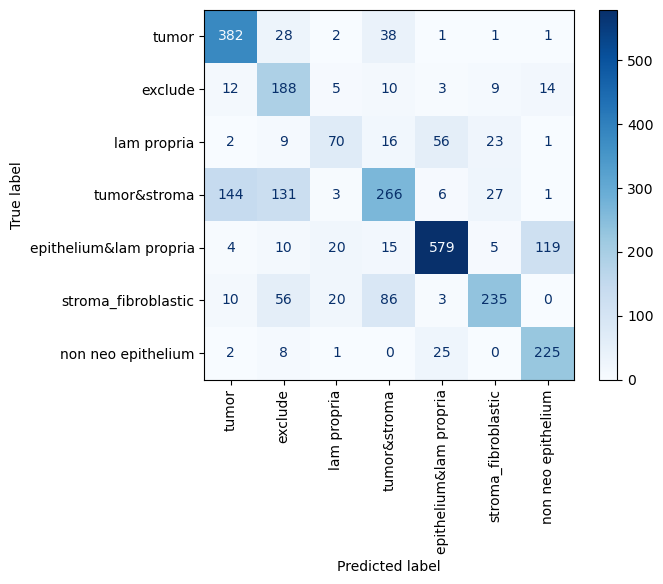

************************************************
../../../config_files/experiments/annotation_transfer/Sample_SN048_A121573_Rep2/config_UNI_multimodal_Least_confidence_sampling_computed_features_norm_im_0_norm_ge_0_ICF_2.json
************************************************
Weighted F1: 0.6775103647286673
Kappa: 0.6176398897170905
[[402  23   2  23   0   2   1]
 [ 19 185  10   8   2   8   9]
 [  4   7  90  12  52  17   1]
 [173 126   7 240   2  28   1]
 [  4  15  29  12 580   3 109]
 [  8  54  24  76   3 246   0]
 [  3  15   0   0  18   0 225]]


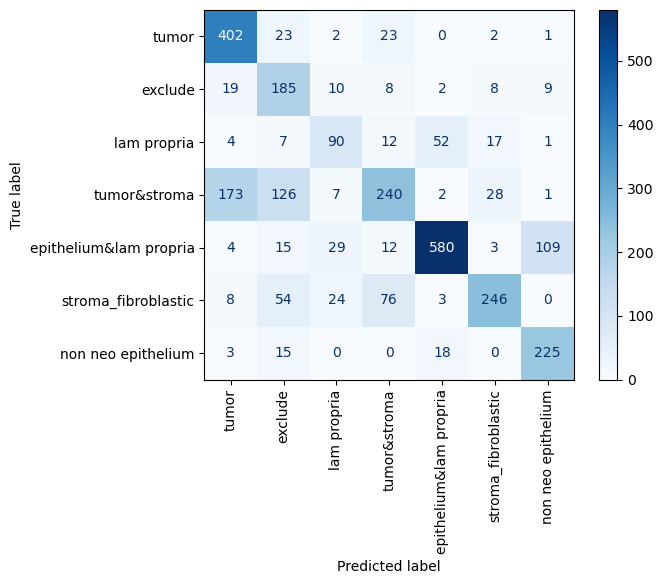

In [18]:
kappa_list = []
labels = None 
conf_matrices = []

for config_file in configs_to_evaluate:
    print('************************************************')
    #print config file in red
    print(f'\033[91m{config_file}\033[0m')
    print('************************************************')
    #create folder if nto exist
    my_configs = config_utils.read_config_from_user_file(config_file)
    runs_home_dir = os.path.join(os.path.dirname(my_configs['model_savepath']))

    predicitons = [filename for filename in os.listdir(runs_home_dir) if filename.startswith(f'Model_predictions_{dataset}_')][0]

    predictions_data = pd.read_csv(os.path.join(runs_home_dir,predicitons))
    # unify annotations
    predictions_data = unify_annotations(predictions_data, colname_in_pred, dataset)
    
    predictions_data.set_index('Barcode', inplace=True)
    common_index = gt_index.intersection(predictions_data.index)
    path_1 = gt_data.loc[common_index]
    path_2 = predictions_data.loc[common_index]
    if labels is None:
        labels = path_1[gt_column_name].unique()
    # calculate Kappa
    kappa = cohen_kappa_score(path_1[gt_column_name], path_2[colname_in_pred])
    # calculate weighted f-score

    weighted_f1 = classification_report(path_1[gt_column_name], path_2[colname_in_pred], output_dict=True)['weighted avg']['f1-score']
    print(f'Weighted F1: {weighted_f1}')

    print(f'Kappa: {kappa}')
    kappa_list.append(kappa)

    # print confusion matrix using ConfusionMatrixDisplay
    cm = confusion_matrix(path_1[gt_column_name], path_2[colname_in_pred], labels=labels)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.show()

    conf_matrices.append(cm)




#### Average performances over all models

Avg Kappa: 0.61 +/- 0.00
Avg Kappa: 0.61 +/- 0.00


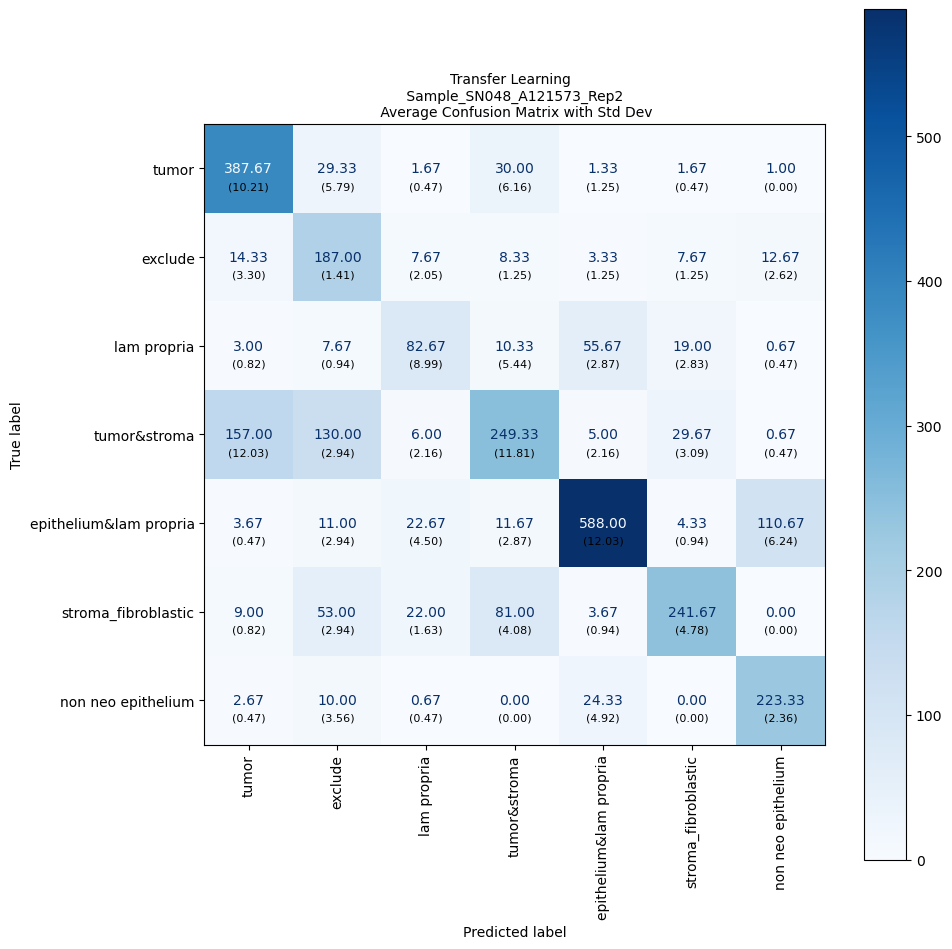

In [19]:

# print avg kappa and std on 2 decimal places
print(f'Avg Kappa: {np.mean(kappa_list):.2f} +/- {np.std(kappa_list):.2f}')
# print avg confusion matrix
avg_confusion_matrix = np.mean(conf_matrices, axis=0)
std_confusion_matrix = np.std(conf_matrices, axis=0)

avg_confusion_matrix = np.round(avg_confusion_matrix, 2)
std_confusion_matrix = np.round(std_confusion_matrix, 2)

print(f'Avg Kappa: {np.mean(kappa_list):.2f} +/- {np.std(kappa_list):.2f}')

# Plot final matrix with std deviation
fig, ax = plt.subplots(figsize=(10, 10))  
disp = ConfusionMatrixDisplay(confusion_matrix=avg_confusion_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format=".2f", ax=ax)

for i in range(avg_confusion_matrix.shape[0]):
    for j in range(avg_confusion_matrix.shape[1]):
        ax.text(j, i + 0.2, f"({std_confusion_matrix[i, j]:.2f})", 
                ha="center", va="center", fontsize=8)  # Std dev (lower position)


plt.title(f"Transfer Learning  \n {dataset} \n Average Confusion Matrix with Std Dev", fontsize=10)
# save figure
plt.tight_layout()
plt.savefig(f'{save_dir}/{dataset}_{mode}_avg_confusion_matrix.png')
plt.show()

# write avg kappa and std to file
with open(f'{save_dir}/{dataset}_{mode}_kappa.txt', 'w') as f:
    f.write(f'Avg Kappa: {np.mean(kappa_list):.2f} +/- {np.std(kappa_list):.2f}')

In [20]:
original_counts = gt_data[gt_column_name].value_counts()
# sort original counts by labels
original_counts = original_counts[labels]

# take diagonal values
correct_predictions = np.diag(avg_confusion_matrix)

correct_predictions = correct_predictions / original_counts
correct_predictions = np.round(correct_predictions * 100, 2)

# print in csv file
correct_predictions_df = pd.DataFrame(correct_predictions)
correct_predictions_df.to_csv(f'{save_dir}{dataset}_{mode}_correct_predictions.csv')


In [21]:
correct_predictions_df

,Pathologist Annotations
tumor,85.02
exclude,76.64
lam propria,44.45
tumor&stroma,42.77
epithelium&lam propria,77.88
stroma_fibroblastic,57.40
non neo epithelium,85.57


In [22]:
# generate Latex table from correct predictions
import tabulate

# replace Pathologist Annotations name with Percentage of correct predictions
correct_predictions_df.columns = ['Percentage of correct predictions']
print(tabulate.tabulate(correct_predictions_df, tablefmt="latex", headers="keys", showindex=True))



\begin{tabular}{lr}
\hline
                        &   Percentage of correct predictions \\
\hline
 tumor                  &                               85.02 \\
 exclude                &                               76.64 \\
 lam propria            &                               44.45 \\
 tumor\&stroma           &                               42.77 \\
 epithelium\&lam propria &                               77.88 \\
 stroma\_fibroblastic    &                               57.4  \\
 non neo epithelium     &                               85.57 \\
\hline
\end{tabular}
